In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torch.distributions import Categorical

sns.set()

In [2]:
DEVICE = 'cpu'

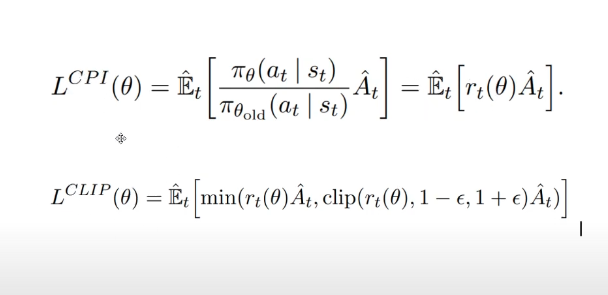

In [3]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, obs_space_size, action_space_size):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(obs_space_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU())
        
        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_space_size))
        
        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1))
    
    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value
    
    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits
    
    def forward(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        value = self.value_layers(z)
        return policy_logits, value
    
    

In [4]:
## create trainer
class PPOTrainer():
    def __init__(self, actor_critic, ppo_clip_val=0.2, target_kl_div=0.01, max_policy_train_iters=80, 
                 value_train_iters=80,policy_lr=3e-4, value_lr=1e-2):
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters

        policy_params = list(self.ac.shared_layers.parameters()) + list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)
        value_params = list(self.ac.shared_layers.parameters()) + list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr=value_lr)
    
    def train_policy(self, obs, acts, old_log_probs, gaes):

        for _ in range(self.max_policy_train_iters):
            self.policy_optim.zero_grad() # zero gradients

            # calculate new logits

            new_logits = self.ac.policy(obs)
            new_logits = Categorical(logits=new_logits)
            new_log_probs = new_logits.log_prob(acts)

            policy_ratio = torch.exp(new_log_probs - old_log_probs) # new / old
            clipped_ratio = policy_ratio.clamp(
                1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
            
            clipped_loss = clipped_ratio * gaes
            full_loss = policy_ratio * gaes
            policy_loss = -torch.min(full_loss, clipped_loss).mean()

            policy_loss.backward()
            self.policy_optim.step()

            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break
    
    def train_values(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()

            values = self.ac.value(obs)
            value_loss = (returns - values) ** 2
            value_loss = value_loss.mean()

            value_loss.backward()
            self.value_optim.step()



In [5]:
## utility functions
def discount_rewards(rewards, gamma=0.99):
    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards) - 1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])

def calculate_gaes(rewards, values, gamma=0.99, decay=0.97):
    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas) - 1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])
    
    return np.array(gaes[::-1])

In [6]:
def rollout(model, env, max_steps=1000):
    train_data = [[], [], [], [], []] # obs, act, reward, values, act_log_probs
    obs, _ = env.reset()

    ep_reward = 0
    for _ in range(max_steps):
        logits, val = model(torch.tensor([obs], dtype=torch.float32, device=DEVICE))
        act_distribution = Categorical(logits=logits)
        act = act_distribution.sample()
        act_log_prob = act_distribution.log_prob(act).item()

        act, val = act.item(), val.item()

        next_obs, reward, done, _, _ = env.step(act)

        # record data for training
        for i, item in enumerate((obs, act, reward, val, act_log_prob)):
            train_data[i].append(item)

        obs = next_obs
        ep_reward += reward
        if done:
            break
    
    train_data = [np.asarray(x) for x in train_data]

    # do train data filtering

    train_data[3] = calculate_gaes(train_data[2], train_data[3])
    return train_data, ep_reward

In [7]:
env = gym.make('CartPole-v1')
model = ActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
model = model.to(DEVICE)
train_data, reward = rollout(model, env) # testing rollout function

/var/folders/n7/7c17qd49613309v3j7cdm95w0000gn/T/ipykernel_48744/3359001554.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  logits, val = model(torch.tensor([obs], dtype=torch.float32, device=DEVICE))


In [7]:
#### Init PPO trainer and params
n_episodes = 200
print_freq = 20



In [ ]:
ppo = PPOTrainer(model,
                policy_lr=3e-4,
                value_lr=1e-3,
                target_kl_div=0.02,
                max_policy_train_iters=40,
                value_train_iters=40)

In [9]:
# training loop
ep_rewards = []
for episode_idx in range(n_episodes):
    train_data, reward = rollout(model, env)
    ep_rewards.append(reward)

    ### Data formatting
    permute_idxs = np.random.permutation(len(train_data[0]))
    obs = torch.tensor(train_data[0][permute_idxs], dtype=torch.float32, device=DEVICE)

    acts = torch.tensor(train_data[1][permute_idxs], dtype=torch.int32, device=DEVICE)

    gaes = torch.tensor(train_data[3][permute_idxs], dtype=torch.float32, device=DEVICE)

    act_log_probs = torch.tensor(train_data[4][permute_idxs], dtype=torch.float32, device=DEVICE)

    # value data
    returns = discount_rewards(train_data[2])[permute_idxs]
    returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    

    ### Policy + value network training
    ppo.train_policy(obs, acts, act_log_probs, gaes)
    ppo.train_values(obs, returns)

    if(episode_idx + 1) % print_freq == 0:
        print(f'Episode {episode_idx + 1} | Avg Reward: {np.mean(ep_rewards[-print_freq:]):.1f}')


Episode 20 | Avg Reward: 13.9
Episode 40 | Avg Reward: 24.6
Episode 60 | Avg Reward: 80.5
Episode 80 | Avg Reward: 82.5
Episode 100 | Avg Reward: 102.0
Episode 120 | Avg Reward: 114.6
Episode 140 | Avg Reward: 117.5
Episode 160 | Avg Reward: 79.9
Episode 180 | Avg Reward: 734.0
Episode 200 | Avg Reward: 672.7


In [10]:
##### NEW TES

In [10]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # Two actions: A (0), B (1)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  # Dummy state
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return np.array([0.0], dtype=np.float32), {}

    def step(self, action):
        reward = 0
        if action == 0:  # A
            reward = 10 if np.random.rand() < 0.75 else 0
        elif action == 1:  # B
            reward = 10 if np.random.rand() < 0.25 else 0

        self.current_step += 1
        done = self.current_step >= 100  # Episode ends after 100 steps

        return np.array([0.0], dtype=np.float32), reward, done, False, {}

# Replace CartPole with CustomEnv
env = CustomEnv()

# Ensure compatibility with the PPO model
model = ActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
model = model.to(DEVICE)

# Test rollout with the custom environment
train_data, reward = rollout(model, env)
print("Test rollout completed with total reward:", reward)

#### Update the training loop to use the new environment
n_episodes = 1000
print_freq = 20

ppo = PPOTrainer(model,
                policy_lr=3e-4,
                value_lr=1e-3,
                target_kl_div=0.02,
                max_policy_train_iters=40,
                value_train_iters=40)

ep_rewards = []
for episode_idx in range(n_episodes):
    train_data, reward = rollout(model, env)
    ep_rewards.append(reward)

    ### Data formatting
    permute_idxs = np.random.permutation(len(train_data[0]))
    obs = torch.tensor(train_data[0][permute_idxs], dtype=torch.float32, device=DEVICE)

    acts = torch.tensor(train_data[1][permute_idxs], dtype=torch.int32, device=DEVICE)

    gaes = torch.tensor(train_data[3][permute_idxs], dtype=torch.float32, device=DEVICE)

    act_log_probs = torch.tensor(train_data[4][permute_idxs], dtype=torch.float32, device=DEVICE)

    # value data
    returns = discount_rewards(train_data[2])[permute_idxs]
    returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    

    ### Policy + value network training
    ppo.train_policy(obs, acts, act_log_probs, gaes)
    ppo.train_values(obs, returns)

    if(episode_idx + 1) % print_freq == 0:
        print(f'Episode {episode_idx + 1} | Avg Reward: {np.mean(ep_rewards[-print_freq:]):.1f}')


Test rollout completed with total reward: 530
Episode 20 | Avg Reward: 270.0
Episode 40 | Avg Reward: 250.0
Episode 60 | Avg Reward: 241.5
Episode 80 | Avg Reward: 251.5
Episode 100 | Avg Reward: 247.0
Episode 120 | Avg Reward: 247.0
Episode 140 | Avg Reward: 237.0
Episode 160 | Avg Reward: 251.0
Episode 180 | Avg Reward: 259.5
Episode 200 | Avg Reward: 232.0
Episode 220 | Avg Reward: 238.5
Episode 240 | Avg Reward: 251.0
Episode 260 | Avg Reward: 253.5
Episode 280 | Avg Reward: 246.0
Episode 300 | Avg Reward: 259.5
Episode 320 | Avg Reward: 251.5
Episode 340 | Avg Reward: 249.5
Episode 360 | Avg Reward: 263.5
Episode 380 | Avg Reward: 253.5
Episode 400 | Avg Reward: 254.5
Episode 420 | Avg Reward: 261.5
Episode 440 | Avg Reward: 264.0
Episode 460 | Avg Reward: 238.0
Episode 480 | Avg Reward: 242.5
Episode 500 | Avg Reward: 255.0
Episode 520 | Avg Reward: 238.0
Episode 540 | Avg Reward: 242.5
Episode 560 | Avg Reward: 244.5
Episode 580 | Avg Reward: 266.5
Episode 600 | Avg Reward: 239.

In [12]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # Two actions: A (0), B (1)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  # Dummy state
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return np.array([0.0], dtype=np.float32), {}

    def step(self, action):
        reward = 0
        if action == 0:  # A
            reward = 10 if np.random.rand() < 0.75 else 0
        elif action == 1:  # B
            reward = 10 if np.random.rand() < 0.25 else 0

        self.current_step += 1
        done = self.current_step >= 100  # Episode ends after 100 steps

        return np.array([0.0], dtype=np.float32), reward, done, False, {}

# Replace CartPole with CustomEnv
env = CustomEnv()

# Ensure compatibility with the PPO model
model = ActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
model = model.to(DEVICE)

# Test rollout with the custom environment
train_data, reward = rollout(model, env)
print("Test rollout completed with total reward:", reward)

#### Update the training loop to use the new environment
n_episodes = 1000
print_freq = 20

ppo = PPOTrainer(model,
                policy_lr=3e-4,
                value_lr=1e-3,
                target_kl_div=0.02,
                max_policy_train_iters=40,
                value_train_iters=40)

ep_rewards = []
for episode_idx in range(n_episodes):
    train_data, reward = rollout(model, env)
    ep_rewards.append(reward)

    ### Data formatting
    permute_idxs = np.random.permutation(len(train_data[0]))
    obs = torch.tensor(train_data[0][permute_idxs], dtype=torch.float32, device=DEVICE)

    acts = torch.tensor(train_data[1][permute_idxs], dtype=torch.int32, device=DEVICE)

    gaes = torch.tensor(train_data[3][permute_idxs], dtype=torch.float32, device=DEVICE)

    act_log_probs = torch.tensor(train_data[4][permute_idxs], dtype=torch.float32, device=DEVICE)

    # value data
    returns = discount_rewards(train_data[2])[permute_idxs]
    returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    

    ### Policy + value network training
    ppo.train_policy(obs, acts, act_log_probs, gaes)
    ppo.train_values(obs, returns)

    if(episode_idx + 1) % print_freq == 0:
        print(f'Episode {episode_idx + 1} | Avg Reward: {np.mean(ep_rewards[-print_freq:]):.1f}')

class PPOTrainer():
    def __init__(self, actor_critic, ppo_clip_val=0.2, target_kl_div=0.01, max_policy_train_iters=80, 
                 value_train_iters=80,policy_lr=3e-4, value_lr=1e-2, entropy_coef=0.01):
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters
        self.entropy_coef = entropy_coef

        policy_params = list(self.ac.shared_layers.parameters()) + list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)
        value_params = list(self.ac.shared_layers.parameters()) + list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr=value_lr)
    
    def train_policy(self, obs, acts, old_log_probs, gaes):

        for _ in range(self.max_policy_train_iters):
            self.policy_optim.zero_grad() # zero gradients

            # calculate new logits

            new_logits = self.ac.policy(obs)
            act_distribution = Categorical(logits=new_logits)
            new_log_probs = act_distribution.log_prob(acts)

            policy_ratio = torch.exp(new_log_probs - old_log_probs) # new / old
            clipped_ratio = policy_ratio.clamp(
                1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
            
            clipped_loss = clipped_ratio * gaes
            full_loss = policy_ratio * gaes
            policy_loss = -torch.min(full_loss, clipped_loss).mean()

            # Add entropy regularization
            entropy_loss = act_distribution.entropy().mean()
            total_loss = policy_loss - self.entropy_coef * entropy_loss

            total_loss.backward()
            self.policy_optim.step()

            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break
    
    def train_values(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()

            values = self.ac.value(obs)
            value_loss = (returns - values) ** 2
            value_loss = value_loss.mean()

            value_loss.backward()
            self.value_optim.step()


Test rollout completed with total reward: 560
Episode 20 | Avg Reward: 282.0
Episode 40 | Avg Reward: 263.5
Episode 60 | Avg Reward: 248.0
Episode 80 | Avg Reward: 248.5
Episode 100 | Avg Reward: 255.0
Episode 120 | Avg Reward: 246.5
Episode 140 | Avg Reward: 251.5
Episode 160 | Avg Reward: 237.0
Episode 180 | Avg Reward: 257.0
Episode 200 | Avg Reward: 243.0
Episode 220 | Avg Reward: 250.0
Episode 240 | Avg Reward: 245.5
Episode 260 | Avg Reward: 241.0
Episode 280 | Avg Reward: 249.0
Episode 300 | Avg Reward: 249.0
Episode 320 | Avg Reward: 252.5
Episode 340 | Avg Reward: 245.0
Episode 360 | Avg Reward: 249.5
Episode 380 | Avg Reward: 257.5
Episode 400 | Avg Reward: 252.0
Episode 420 | Avg Reward: 237.0
Episode 440 | Avg Reward: 253.5
Episode 460 | Avg Reward: 242.5
Episode 480 | Avg Reward: 248.0
Episode 500 | Avg Reward: 246.0
Episode 520 | Avg Reward: 251.0
Episode 540 | Avg Reward: 264.5
Episode 560 | Avg Reward: 241.5
Episode 580 | Avg Reward: 236.0
Episode 600 | Avg Reward: 237.

In [21]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # Two actions: A (0), B (1)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  # Dummy state
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return np.array([0.0], dtype=np.float32), {}

    def step(self, action):
        reward = 0
        if action == 0:  # A
            reward = 10 if np.random.rand() < 0.75 else 0
        elif action == 1:  # B
            reward = 10 if np.random.rand() < 0.25 else 0

        self.current_step += 1
        done = self.current_step >= 100  # Episode ends after 100 steps

        return np.array([0.0], dtype=np.float32), reward, done, False, {}

# Replace CartPole with CustomEnv
env = CustomEnv()

# Ensure compatibility with the PPO model
model = ActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
model = model.to(DEVICE)

# Test rollout with the custom environment
train_data, reward = rollout(model, env)
print("Test rollout completed with total reward:", reward)

#### Update the training loop to use the new environment
n_episodes = 200
print_freq = 20

ppo = PPOTrainer(model,
                policy_lr=3e-4,
                value_lr=1e-3,
                target_kl_div=0.02,
                max_policy_train_iters=40,
                value_train_iters=40)

ep_rewards = []
for episode_idx in range(n_episodes):
    train_data, reward = rollout(model, env)
    ep_rewards.append(reward)

    ### Data formatting
    permute_idxs = np.random.permutation(len(train_data[0]))
    obs = torch.tensor(train_data[0][permute_idxs], dtype=torch.float32, device=DEVICE)

    acts = torch.tensor(train_data[1][permute_idxs], dtype=torch.int32, device=DEVICE)

    gaes = torch.tensor(train_data[3][permute_idxs], dtype=torch.float32, device=DEVICE)

    act_log_probs = torch.tensor(train_data[4][permute_idxs], dtype=torch.float32, device=DEVICE)

    # value data
    returns = discount_rewards(train_data[2])[permute_idxs]
    returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    

    ### Policy + value network training
    ppo.train_policy(obs, acts, act_log_probs, gaes)
    ppo.train_values(obs, returns)

    if(episode_idx + 1) % print_freq == 0:
        print(f'Episode {episode_idx + 1} | Avg Reward: {np.mean(ep_rewards[-print_freq:]):.1f}')

class PPOTrainer():
    def __init__(self, actor_critic, ppo_clip_val=0.2, target_kl_div=0.01, max_policy_train_iters=80, 
                 value_train_iters=80,policy_lr=3e-4, value_lr=1e-2, entropy_coef=0.01):
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters
        self.entropy_coef = entropy_coef

        policy_params = list(self.ac.shared_layers.parameters()) + list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)
        value_params = list(self.ac.shared_layers.parameters()) + list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr=value_lr)
    
    def train_policy(self, obs, acts, old_log_probs, gaes):

        for _ in range(self.max_policy_train_iters):
            self.policy_optim.zero_grad() # zero gradients

            # calculate new logits

            new_logits = self.ac.policy(obs)
            act_distribution = Categorical(logits=new_logits)
            new_log_probs = act_distribution.log_prob(acts)

            policy_ratio = torch.exp(new_log_probs - old_log_probs) # new / old
            clipped_ratio = policy_ratio.clamp(
                1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
            
            clipped_loss = clipped_ratio * gaes
            full_loss = policy_ratio * gaes
            policy_loss = -torch.min(full_loss, clipped_loss).mean()

            # Add entropy regularization
            entropy_loss = act_distribution.entropy().mean()
            total_loss = policy_loss - self.entropy_coef * entropy_loss

            total_loss.backward()
            self.policy_optim.step()

            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break
    
    def train_values(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()

            values = self.ac.value(obs)
            value_loss = (returns - values) ** 2
            value_loss = value_loss.mean()

            value_loss.backward()
            self.value_optim.step()


Test rollout completed with total reward: 520
Episode 20 | Avg Reward: 267.5
Episode 40 | Avg Reward: 254.0
Episode 60 | Avg Reward: 246.5
Episode 80 | Avg Reward: 244.5
Episode 100 | Avg Reward: 243.5
Episode 120 | Avg Reward: 245.5
Episode 140 | Avg Reward: 264.5
Episode 160 | Avg Reward: 224.0
Episode 180 | Avg Reward: 252.0
Episode 200 | Avg Reward: 249.0
